In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from datetime import date
from scipy.stats import norm 
import os

SYMBOL = "TSLA"
START_DATE = "2023-01-01"
END_DATE = "2023-12-30"

In [12]:
%load_ext dotenv
%dotenv
access_token = os.environ.get("access_token")

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [13]:
# Synthetic Long Simulation
class Portfolio:
    def __init__(self, options: list):
        self.options = options
        cost_per_trade = np.sum([x.premium for x in self.options])
        self.cost = cost_per_trade
        print("Cost per trade: ", cost_per_trade)

    def getPriceInformation(self, prices: list):
        outputs = [0] * len(prices)
        for option in self.options:
            outputs = [x + y for x, y in zip(outputs, option.getPriceInformation(prices))]
        return outputs
    
    def getReturn(self, price: float, option_allocation: float):
        sum = 0

        num_of_trades = np.floor(option_allocation / self.cost)
        
        for option in self.options:
            sum += option.getReturn(price) * num_of_trades
        
        return sum
    
class OptionContract:
    def __init__(self, strike: float, premium: float, type: str, side: str):
        self.strike = strike
        self.premium = premium
        self.type = type
        self.side = side
    
    def getPriceInformation(self, prices: list):
        if(self.type == 'Call'):
            if(self.side == 'Long'):
                return [max(0, price - self.strike) - self.premium for price in prices]
            else:
                return [self.premium - max(0, price - self.strike) for price in prices]
        else:
            if(self.side == 'Long'):
                return [max(0, self.strike - price) - self.premium for price in prices]
            else:
                return [self.premium - max(0, self.strike - price) for price in prices]
    
    def getReturn(self, price: float):
        if(self.type == 'Call'):
            if(self.side == 'Long'):
                return max(0, price - self.strike) - self.premium
            else:
                return self.premium - max(0, price - self.strike)
        else:
            if(self.side == 'Long'):
                return max(0, self.strike - price) - self.premium
            else:
                return self.premium - max(0, self.strike - price)

In [14]:
response = requests.get('https://api.tradier.com/v1/markets/history',
    params={'symbol': SYMBOL, 'interval': 'daily', 'start': START_DATE, 'end': END_DATE, 'session_filter': 'all'},
    headers={'Authorization': 'Bearer ' + access_token, 'Accept': 'application/json'}
)

json_response = response.json()
data = pd.DataFrame(json_response['history']['day'])

data['date'] = pd.to_datetime(data['date'])

count = data['open'].count()

mean = data['open'].sum() / count

print("Mean:", mean)

data['residual'] = data['open'] - mean
data['rs'] = pow(data['residual'], 2)

variance = data['rs'].sum() / count

print("Variance:", variance)
print("Count:", data['rs'].count())

# display(data)

daily_std = np.sqrt(variance) / np.sqrt(count)
print("Daiy Standard Deviation:", daily_std)

Mean: 217.10681680000002
Variance: 1783.9911018769978
Count: 250
Daiy Standard Deviation: 2.6713225951779003


In [15]:
response = requests.get('https://api.tradier.com/v1/markets/options/expirations',
    params={'symbol': SYMBOL, 'includeAllRoots': 'true', 'contractSize': 'true', 'expirationType': 'true'},
    headers={'Authorization': 'Bearer ' + access_token, 'Accept': 'application/json'}
)
json_response = response.json()
dates = [entry['date'] for entry in json_response['expirations']['expiration']]
print(dates)

['2024-01-12', '2024-01-19', '2024-01-26', '2024-02-02', '2024-02-09', '2024-02-16', '2024-02-23', '2024-03-15', '2024-04-19', '2024-05-17', '2024-06-21', '2024-07-19', '2024-09-20', '2025-01-17', '2025-06-20', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18']


In [17]:
expiration = dates[8]

today = date.today()
NUM_OF_DAYS = np.busday_count(today, expiration)

response = requests.get('https://api.tradier.com/v1/markets/options/chains',
    params={'symbol': SYMBOL, 'expiration': expiration, 'greeks': 'true'},
    # params={'symbol': SYMBOL, 'expiration': expiration},
    headers={'Authorization': 'Bearer ' + access_token, 'Accept': 'application/json'}
)
json_response = response.json()

call_strikes = [entry['strike'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]
call_bids = [entry['ask'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]
call_asks = [entry['bid'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]

put_strikes = [entry['strike'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]
put_bids = [entry['bid'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]
put_asks = [entry['ask'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]

put_data = zip(put_strikes, put_bids, put_asks)
call_data = zip(put_strikes, put_bids, put_asks)

In [18]:
response = requests.get('https://api.tradier.com/v1/markets/quotes',
    params={'symbols': SYMBOL, 'greeks': 'false'},
    headers={'Authorization': 'Bearer ' + access_token, 'Accept': 'application/json'}
)
json_response = response.json()
print(response.status_code)
price = json_response['quotes']['quote']['last']
print("Price:", price)

200
Price: 237.49


Adjusted Standard Deviation: 22.979585856920732
Call ATM:  240.0 Put ATM:  240.0 OTM:  265.0
Cost per trade:  61.85
Intersection: $ 226.55124242923782


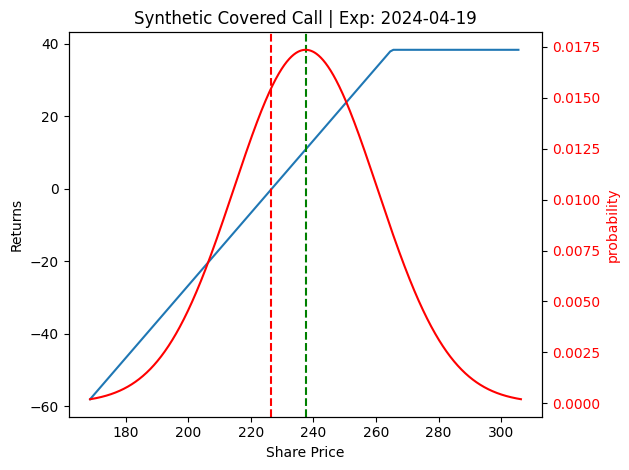

In [20]:
std = daily_std * np.sqrt(NUM_OF_DAYS)
print("Adjusted Standard Deviation:", std)

STD_WIDTH = 3
prices = np.arange(price - STD_WIDTH * std, price + STD_WIDTH * std, 1)

def getStrikeNearPrice(strikes: list, price: float):
    for i in range(len(strikes)):
        if strikes[i] != None and strikes[i] > price:
            return strikes[i], i

C_ATM_STRIKE, CALL_ATM_INDEX = getStrikeNearPrice(call_strikes, price)
C_ATM_PREMIUM = call_asks[CALL_ATM_INDEX]

P_ATM_STRIKE, PUT_ATM_INDEX = getStrikeNearPrice(put_strikes, price)
P_ATM_PREMIUM = put_bids[PUT_ATM_INDEX]

C_OTM_STRIKE, CALL_OTM_INDEX = getStrikeNearPrice(call_strikes, price + std)
C_OTM_PREMIUM = call_bids[CALL_OTM_INDEX]

print("Call ATM: ", C_ATM_STRIKE, "Put ATM: ", P_ATM_STRIKE, "OTM: ", C_OTM_STRIKE)

covered_call_strat = Portfolio([
    # ATM LONG CALL
    OptionContract(C_ATM_STRIKE, C_ATM_PREMIUM, 'Call', 'Long'),
    
    # ATM SHORT PUT
    OptionContract(P_ATM_STRIKE, P_ATM_PREMIUM, 'Put', 'Short'),
    
    # OTM SHORT CALL
    OptionContract(C_OTM_STRIKE, C_OTM_PREMIUM, 'Call', 'Short'),
])

fig, ax1 = plt.subplots()
ax1.title.set_text("Synthetic Covered Call | Exp: " + expiration)

values = covered_call_strat.getPriceInformation(prices)

# Binary search to find 0 in values
notFound = True
intersection = 0

start = 0
end = len(values) - 1

while notFound:
    section = values[start:end]
    mid = len(section) // 2

    # print(start, end, mid, section[mid])
    # print(section)
    
    if section[mid] > 0:
        end -= mid
    
    elif section[mid] < 0:
        start += mid
    
    if(len(section) <= 1):
        intersection = start
        notFound = False

print("Intersection: $", prices[intersection])

ax1.plot(prices, values)
ax1.set_xlabel('Share Price')
ax1.set_ylabel('Returns', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.axvline(x=prices[intersection], color='r', linestyle='--')
ax1.axvline(x=price, color='g', linestyle='--')

ax2 = ax1.twinx()

x_axis = np.arange(price-STD_WIDTH*std, price+STD_WIDTH*std, 0.1) 

ax2.plot(x_axis, norm.pdf(x_axis, price, std), color='r')
ax2.set_ylabel('probability', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.show()

In [21]:
drift = 0
class MonteCarloSimulation:
    def __init__(self, trials: int, steps: int, price: float, volatility: float, funds: float):
        self.start_price = price
        self.volatility = volatility
        self.steps = steps
        self.funds = funds
        self.trials = trials

        self.current_price = self.start_price
        self.price_history = [self.current_price]
        self.funds_history = [self.funds]

    def run(self, cash_allocation: float, option_allocation: float, daily_interest_rate = .000137, display: bool = False):
        if(cash_allocation + option_allocation != 1):
            raise Exception("Cash and Option Allocation must be equal than 1")
        returns = []
        interest = (cash_allocation * self.funds) * self.steps * daily_interest_rate

        for trial in range(self.trials):
            for tick in range(self.steps):
                new_price = self.current_price + np.random.normal(drift, self.volatility)
                self.current_price = new_price
                self.price_history.append(new_price)

            if display:
                plt.plot(self.price_history)
            
            allocation = option_allocation * self.funds
            option_returns = covered_call_strat.getReturn(self.current_price, allocation)
            
            self.current_price = self.start_price
            self.price_history = [self.current_price]

            result = option_returns + interest
            # print("Returns:", result, "Options:", option_returns,"Interest:", interest)
            # self.funds += result

            returns.append(result)
            # self.funds_history.append(self.funds)

            if(self.funds <= 0):
                return returns

        if display:
            plt.title("Monte Carlo Simulation of " + SYMBOL + " | " + str(self.trials) + " Trials")
            plt.xlabel("Price")
            plt.ylabel("Time (Days)")
            plt.show()
            # plt.plot(self.funds_history)
            # plt.title("Return's Simulation of " + SYMBOL + " | " + str(self.trials) + " Trials")
            # plt.ylabel("Value")
            # plt.xlabel("Time (" + str(NUM_OF_DAYS) + " days)")
            # plt.show()
        
        return returns

In [22]:
# Optimal Allocation Optimization
STARTING_BALANCE = 100_000
NUM_TRIALS = 1

df = pd.DataFrame(columns=['Option Allocation', 'Cash Allocation', 'Returns', 'Max Drawdown', 'Sharpe Ratio'])

option_allocations = np.arange(0, 1, 0.01)

for option_allocation in option_allocations:
    cash_allocation = 1 - option_allocation

    simulation = MonteCarloSimulation(NUM_TRIALS, NUM_OF_DAYS, price, daily_std, STARTING_BALANCE)
    results = simulation.run(cash_allocation, option_allocation, display=False)

    temp = pd.DataFrame({
        'Option Allocation': option_allocation,
        'Cash Allocation': cash_allocation,
        'Returns': np.mean(results),
        'Max Drawdown': np.abs(np.min(results)),
        'Sharpe Ratio': np.mean(results) / np.std(results)
    }, index=[0])

    df = pd.concat([df, temp])

display(df)

C:\Users\trevo\AppData\Local\Temp\ipykernel_9588\1305569635.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  'Sharpe Ratio': np.mean(results) / np.std(results)


,Option Allocation,Cash Allocation,Returns,Max Drawdown,Sharpe Ratio
0,0.00,1.00,1013.800000,1013.800000,inf
0,0.01,0.99,876.585862,876.585862,inf
0,0.02,0.98,1557.065610,1557.065610,inf
0,0.03,0.97,1316.297909,1316.297909,inf
0,0.04,0.96,-491.036942,491.036942,-inf
...,...,...,...,...,...
0,0.95,0.05,49924.956063,49924.956063,inf
0,0.96,0.04,26337.340077,26337.340077,inf
0,0.97,0.03,19925.678488,19925.678488,inf
0,0.98,0.02,3401.658344,3401.658344,inf


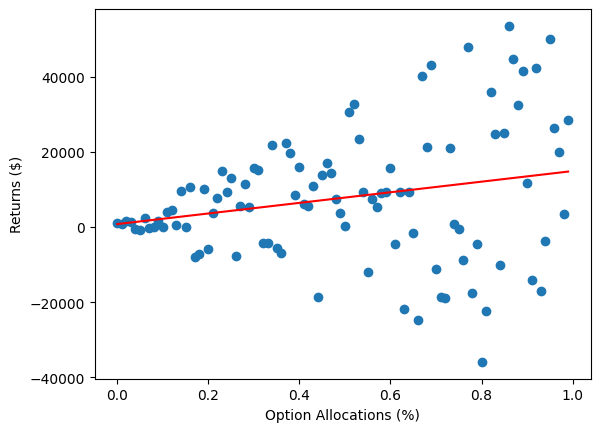

Slope: 14098.802763597827
Intercept: 764.9347554951792
R-value: 0.23432354661069132
P-value: 0.018948373196982702
Standard error: 5908.679287191281


In [23]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df['Option Allocation'], df['Returns'])
plt.plot(df['Option Allocation'], slope*df['Option Allocation'] + intercept, color='red')

plt.scatter(df['Option Allocation'], df['Returns'])
plt.xlabel('Option Allocations (%)')
plt.ylabel('Returns ($)')
plt.show()

print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("P-value:", p_value)
print("Standard error:", std_err)

# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(df['Max Drawdown'], df['Option Allocation'], df['Returns'])
# ax.set_xlabel('Max Drawdown (Percentage)')
# ax.set_zlabel('Avg. Returns ($)')
# ax.set_ylabel('Option Allocaation (%)')
# plt.show()

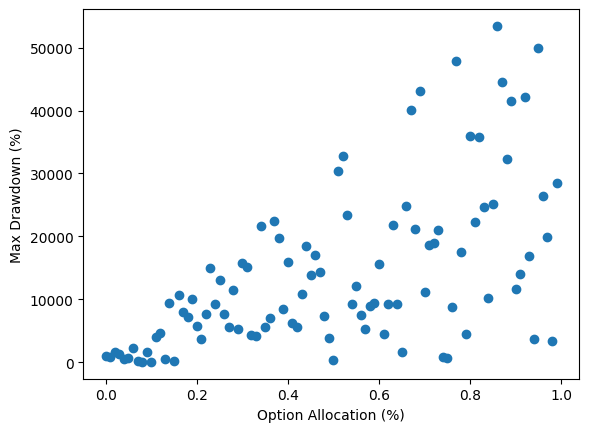

In [24]:
plt.scatter(df['Option Allocation'], df['Max Drawdown'])
plt.xlabel('Option Allocation (%)')
plt.ylabel('Max Drawdown (%)')
plt.show()

In [27]:
STARTING_BALANCE = 100_000
NUM_TRIALS = 1000

simulation = MonteCarloSimulation(NUM_TRIALS, NUM_OF_DAYS, price, daily_std, STARTING_BALANCE)
results = simulation.run(0.95, 0.05, display=False)

print("Average Return:", np.mean(results))

Average Return: 1698.0865521265375
